딥러닝응용 4주차 과제
==
Pretrain CNN Model + Fine-Tuning
* * *
- tf implementation
- error resolved
- new error: train_loss, val_loss in fine-tuning process = 0
- submission #2


In [1]:
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit
from scipy.stats import skew
import os
import csv
import pandas as pd
from tqdm import tqdm

## Load Data


In [2]:
df = pd.read_csv("diabetes.csv")

In [3]:
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [4]:
df.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

In [5]:
df['Outcome'].value_counts()

,count
Outcome,
0,500
1,268


Text(0, 0.5, 'Count')

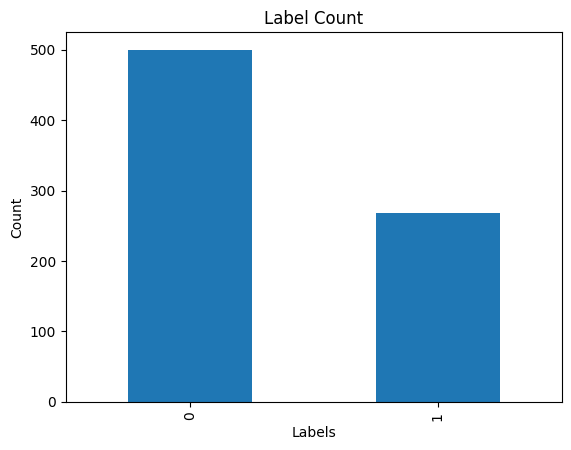

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# 레이블별 갯수 확인
label_counts = df['Outcome'].value_counts()

# 바 그래프 그리기
label_counts.plot(kind='bar')

# 그래프 제목 및 라벨 설정
plt.title('Label Count')
plt.xlabel('Labels')
plt.ylabel('Count')

In [8]:
df_Y=df['Outcome']

In [9]:
df_X=df.drop('Outcome',axis=1)
df_X.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,6,148,72,35,0,33.6,0.627,50
1,1,85,66,29,0,26.6,0.351,31
2,8,183,64,0,0,23.3,0.672,32
3,1,89,66,23,94,28.1,0.167,21
4,0,137,40,35,168,43.1,2.288,33


In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_X,
                                                    df_Y,
                                                    test_size = 0.25,
                                                    random_state = 21)

In [12]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((576, 8), (192, 8), (576,), (192,))

In [13]:
from collections import Counter
import numpy as np

def split_sequences(sequences, n_steps):
    X, y = list(), list()  # 빈 리스트를 생성하여 시퀀스 데이터와 레이블을 담을 공간을 만듦
    for i in range(len(sequences)):  # 전체 시퀀스 데이터를 순회
        # find the end of this pattern
        end_ix = i + n_steps  # 현재 인덱스(i)에서 n_steps만큼 떨어진 시퀀스의 끝을 계산
        # check if we are beyond the dataset
        if end_ix > len(sequences):  # 시퀀스 끝이 데이터의 범위를 넘어서는지 확인
            break  # 범위를 넘으면 루프 종료
        # gather input (X) and output parts (y)
        seq_x = sequences[i:end_ix, :-1]  # 입력 데이터 (특징 데이터)
        seq_y_values = sequences[i:end_ix, -1]  # 시퀀스 동안의 출력 데이터 (레이블들)

        # 가장 빈번하게 나온 레이블 찾기
        most_common_label = Counter(seq_y_values).most_common(1)[0][0]

        X.append(seq_x)  # 입력 데이터 추가
        y.append(most_common_label)  # 가장 많이 나온 레이블 추가

    return np.array(X), np.array(y)  # 리스트를 numpy 배열로 변환하여 반환

In [14]:
# Merge train and test X/y data to apply sequence transformation function
y_train_array = np.array(y_train)
train_set = np.c_[X_train, y_train_array]

y_test_array = np.array(y_test)
test_set = np.c_[X_test, y_test_array]

In [19]:
n_step = 5

X_train_seq, y_train_seq = split_sequences(train_set, n_step)
print(X_train_seq.shape, y_train_seq.shape)

X_test_seq, y_test_seq = split_sequences(test_set, n_step)
print(X_test_seq.shape, y_test_seq.shape)

(572, 5, 8) (572,)
(188, 5, 8) (188,)


In [20]:
from keras.utils import to_categorical

# Convert output variables to categorical for CNN
y_train_seq = to_categorical(y_train_seq)
print(y_train_seq.shape)

y_test_seq = to_categorical(y_test_seq)
print(y_test_seq.shape)

(572, 2)
(188, 2)


In [21]:
# Produce variables for CNN input/output shape
n_timesteps, n_features, n_outputs = X_train_seq.shape[1], X_train_seq.shape[2], y_train_seq.shape[1]
print(n_timesteps, n_features, n_outputs)

5 8 2


In [22]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# cnn model vary kernel size
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from matplotlib import pyplot
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from keras.utils import to_categorical

import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Reshape, LSTM, Conv1D, MaxPooling1D
from tensorflow.keras.layers import TimeDistributed, Conv1D, MaxPooling1D

In [25]:
# Sequential model type
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', padding='same', input_shape=(n_timesteps, n_features)))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())  # Flatten the output to feed into a dense layer
model.add(Dense(128, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))  # Use 'sigmoid' for binary classification

model.compile(optimizer='adam', metrics=['accuracy'], loss='categorical_crossentropy')

In [26]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)                    │ (None, 5, 32)               │             800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 2, 32)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 2, 64)               │           6,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 1, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,586 (60.88 KB)

 Trainable params: 15,586 (60.88 KB)

 Non-trainable params: 0 (0.00 B)

In [28]:
history = model.fit(X_train_seq, y_train_seq, epochs = 20, batch_size = 8, validation_split = 0.1, shuffle = True)

Epoch 1/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.8179 - loss: 0.6424 - val_accuracy: 0.5690 - val_loss: 1.8712
Epoch 2/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7692 - loss: 0.8759 - val_accuracy: 0.6552 - val_loss: 1.0186
Epoch 3/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8392 - loss: 0.3640 - val_accuracy: 0.5345 - val_loss: 2.6576
Epoch 4/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8461 - loss: 0.4066 - val_accuracy: 0.7069 - val_loss: 1.1265
Epoch 5/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8503 - loss: 0.2913 - val_accuracy: 0.6552 - val_loss: 0.9383
Epoch 6/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8938 - loss: 0.2730 - val_accuracy: 0.6207 - val_loss: 0.8886
Epoch 7/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8810 - loss: 0.2634 - val_accuracy: 0.5000 - val_loss: 2.1911
Epoch 8/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8869 - loss: 0.3234 - val_accuracy: 0.7759 - val_loss

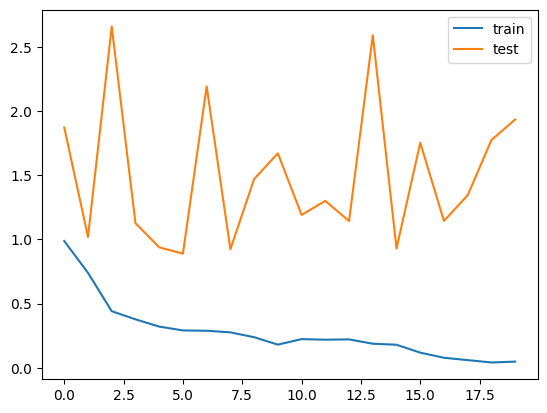

In [29]:
plt.plot(history.history["loss"], label = "train")
plt.plot(history.history["val_loss"], label = "test")
plt.legend()

In [30]:
model.evaluate(X_train_seq, y_train_seq)

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.9833 - loss: 0.0882


[0.24455952644348145, 0.9510489702224731]

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step
Confusion Matrix


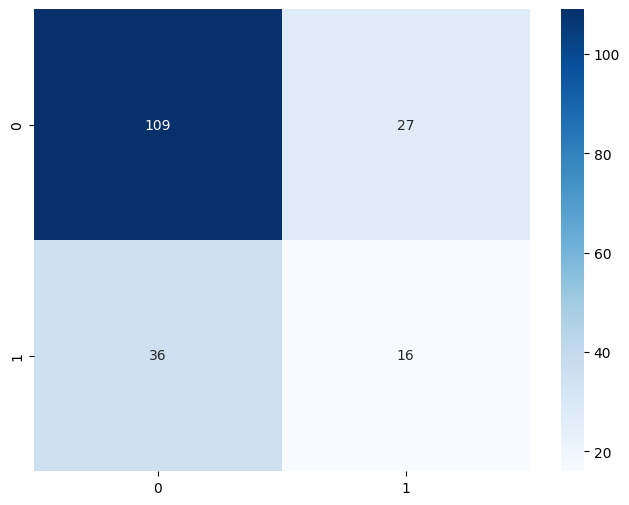

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

y_test_arg=np.argmax(y_test_seq, axis=1)
Y_pred = np.argmax(model.predict(X_test_seq),axis=1)
print('Confusion Matrix')
cm = confusion_matrix(y_test_arg, Y_pred)
# 시각화
plt.figure(figsize=(8, 6))  # 그래프 크기 조절 (너비 8, 높이 6)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

# 그래프 표시
plt.show()

In [33]:
base_loss,base_accuracy=model.evaluate(X_test_seq, y_test_seq)

model_file='Model.h5'

tf.keras.models.save_model(model, model_file, include_optimizer=False)
print('model saved at ', model_file)
#score,keras_file=evaluate_model(trainX,trainy,testX,testy)
score=base_accuracy*100
print('Accuracy >{:f}'.format(score))
print('Base Loss >{:.2f}'.format(base_loss))

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6574 - loss: 1.4613 


model saved at  Model.h5
Accuracy >66.489363
Base Loss >1.43


전이 학습 및 미세 조정
==

In [34]:
# # Base 모델을 로드 (
from tensorflow.keras.models import load_model

base_model = load_model(model_file)

In [35]:
# base_model.compile(optimizer='adam', metrics=['accuracy'], loss='categorical_crossentropy')
# base_model.evaluate(X_test_seq_LA, y_test_seq_LA)

base_model.compile(optimizer='adam', metrics=['accuracy'], loss='categorical_crossentropy')
base_model.evaluate(X_test_seq, y_test_seq)

6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 202ms/step - accuracy: 0.6574 - loss: 1.4613


[1.4340704679489136, 0.664893627166748]

In [36]:
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  7


In [39]:
# 기존 모델의 층을 동결 (학습되지 않도록 설정)
base_model.trainable = False

# 새로운 모델을 정의
new_model = Sequential()

# 기존 모델을 추가
new_model.add(base_model)

# 새로운 완전연결층 추가
new_model.add(layers.Dense(64, activation='relu'))  # 기존 출력층 앞의 레이어 대신 추가

# 최종 출력층 추가
new_model.add(layers.Dense(2, activation='softmax'))

new_model.compile(optimizer='adam', metrics=['accuracy'], loss='categorical_crossentropy')

# 모델 요약 출력
new_model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_2 (Sequential)            │ (None, 2)                   │          15,586 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,586 (60.88 KB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 15,586 (60.88 KB)

In [40]:
import pandas as pd
display_layers = [(layer, layer.name, layer.trainable) for layer in new_model.layers]
pd.DataFrame(display_layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

,Layer Type,Layer Name,Layer Trainable
0,"<Sequential name=sequential_2, built=True>",sequential_2,False
1,"<Dense name=dense_6, built=False>",dense_6,True
2,"<Dense name=dense_7, built=False>",dense_7,True


In [44]:
# new_model.summary()
history3 = new_model.fit(X_train_seq, y_train_seq, epochs = 20, batch_size = 8, validation_split = 0.1, shuffle = True)

new_model.summary()

Epoch 1/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.9958 - loss: 0.0000e+00 - val_accuracy: 0.6034 - val_loss: 0.0000e+00
Epoch 2/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9975 - loss: 0.0000e+00 - val_accuracy: 0.5862 - val_loss: 0.0000e+00
Epoch 3/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9984 - loss: 0.0000e+00 - val_accuracy: 0.5862 - val_loss: 0.0000e+00
Epoch 4/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9959 - loss: 0.0000e+00 - val_accuracy: 0.5862 - val_loss: 0.0000e+00
Epoch 5/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9986 - loss: 0.0000e+00 - val_accuracy: 0.5862 - val_loss: 0.0000e+00
Epoch 6/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9979 - loss: 0.0000e+00 - val_accuracy: 0.5862 - val_loss: 0.0000e+00
Epoch 7/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9941 - loss: 0.0000e+00 - val_accuracy: 0.5862 - val_loss: 0.0000e+00
Epoch 8/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy:

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_2 (Sequential)            │ (None, 2)                   │          15,586 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 64)                  │             192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,554 (64.67 KB)

 Trainable params: 322 (1.26 KB)

 Non-trainable params: 15,586 (60.88 KB)

 Optimizer params: 646 (2.53 KB)

In [45]:
new_model.evaluate(X_test_seq, y_test_seq)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6791 - loss: 0.0000e+00


[0.0, 0.0, 0.6808510422706604, 0.6808510422706604]

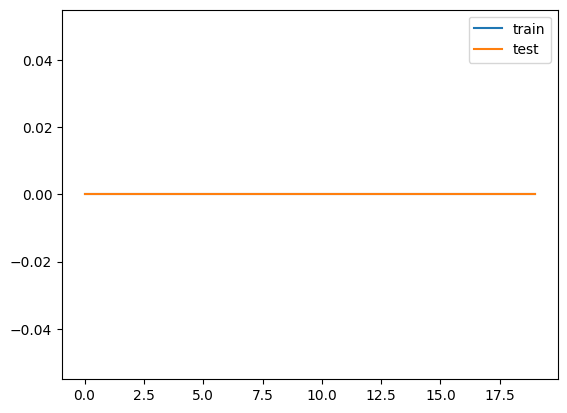

In [47]:
plt.plot(history3.history["loss"], label = "train")
plt.plot(history3.history["val_loss"], label = "test")
plt.legend()

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step
Confusion Matrix


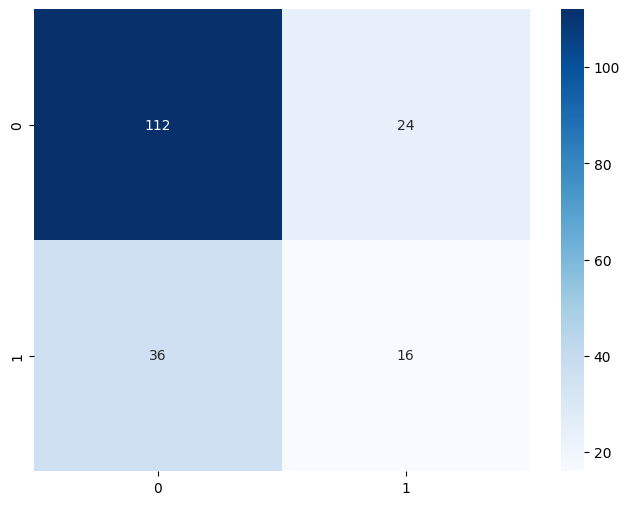

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

y_test_arg=np.argmax(y_test_seq, axis=1)
Y_pred = np.argmax(new_model.predict(X_test_seq),axis=1)
print('Confusion Matrix')
cm = confusion_matrix(y_test_arg, Y_pred)
# 시각화
plt.figure(figsize=(8, 6))  # 그래프 크기 조절 (너비 8, 높이 6)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

# 그래프 표시
plt.show()